In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
from datetime import timedelta

from IPython.display import display, HTML

import matplotlib.pyplot as plt
import seaborn as sns

import osrs_GE

pd.set_option('display.float_format', lambda x: '%.5f' % x)

C:\Users\Cody\Documents\Python Scripts\osrs ge project\osrs-ge\osrs_GE.py:226: SyntaxWarning: invalid escape sequence '\W'
  id,interval = re.split("\W+|_",f)[-3:-1]


---

In [57]:
# find a way to deal with dates being read in without the H M S

# /Users/codycao/Documents/Data projects/OSRS GE/osrs_GE.py:201: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
#  df['date'] = pd.to_datetime(df['date'])
item_id = 11284

interval = '24h'

df = osrs_GE.read_item_master_file(item_id,interval)
df.index = pd.DatetimeIndex(df.index.values,freq=df.index.inferred_freq)
df = osrs_GE.compute_VWAP(df)
df.head()

File read successfully for Master Files/items/master_file_11284_24h.csv


,timestamp,avgHighPrice,avgLowPrice,highPriceVolume,lowPriceVolume,VWAP
2023-09-13,1694563200,2047178,2019160,925,792,2034254.14677
2023-09-14,1694649600,2072889,2044184,950,963,2058438.96602
2023-09-15,1694736000,2100419,2067689,1062,914,2085279.71862
2023-09-16,1694822400,2110317,2076963,1243,972,2095680.39142
2023-09-17,1694908800,2113039,2080300,1428,1105,2098756.88591


In [59]:
#df = compute_n_simple_return(df,n=7)
df['simpRet'] = (df['VWAP']/df['VWAP'].shift(1))-1
df.head(10)

,timestamp,avgHighPrice,avgLowPrice,highPriceVolume,lowPriceVolume,VWAP,simpRet
2023-09-13,1694563200,2047178,2019160,925,792,2034254.14677,NaN
2023-09-14,1694649600,2072889,2044184,950,963,2058438.96602,0.01189
2023-09-15,1694736000,2100419,2067689,1062,914,2085279.71862,0.01304
2023-09-16,1694822400,2110317,2076963,1243,972,2095680.39142,0.00499
2023-09-17,1694908800,2113039,2080300,1428,1105,2098756.88591,0.00147
2023-09-18,1694995200,2091456,2057883,792,641,2076438.34962,-0.01063
2023-09-19,1695081600,2154935,2127641,1074,867,2142743.39876,0.03193
2023-09-20,1695168000,2302478,2234199,1030,1073,2267640.45031,0.05829
2023-09-21,1695254400,2301252,2261995,1082,1037,2282040.33931,0.00635
2023-09-22,1695340800,2379178,2338632,1088,893,2360900.57547,0.03456


In [61]:
# create train test split
df = df.dropna()
train_idx = int(.7*df.index.shape[0])
#train_dt = df.index[train_idx]
train_dt = '2024-05-19'

df_tr = df[df.index < train_dt]
df_te = df[df.index >= train_dt]

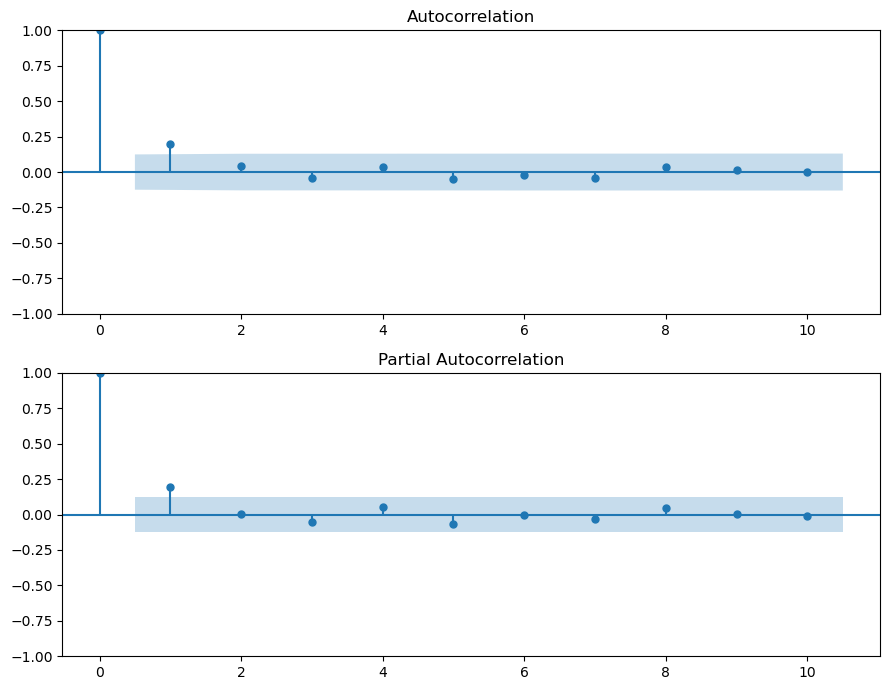

In [65]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(9, 7))
plot_acf(df_tr['simpRet'],lags=10, ax=ax[0])
plot_pacf(df_tr['simpRet'],lags=10, ax=ax[1], method='ols')

plt.tight_layout()
plt.show()

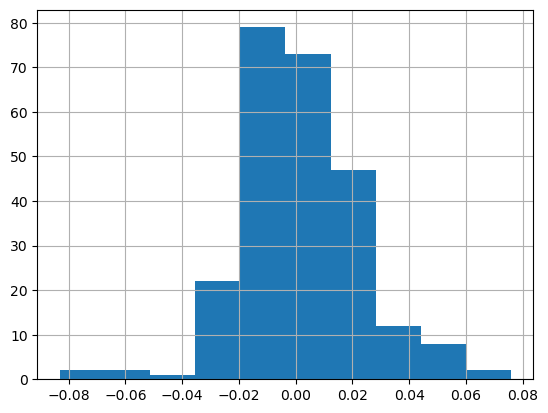

In [67]:
df_tr['simpRet'].hist()
plt.show()

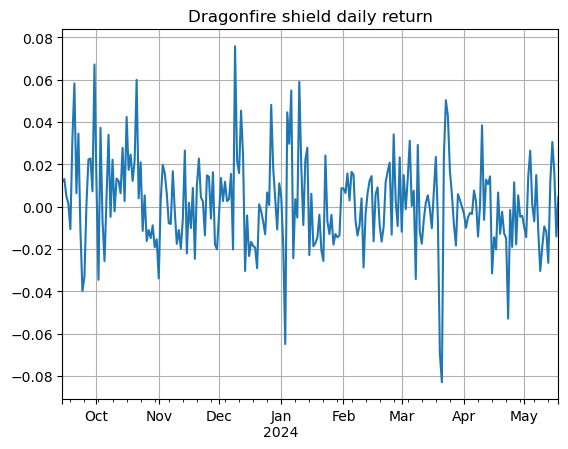

In [69]:
df_tr['simpRet'].plot()
plt.title('{} daily return'.format(osrs_GE.item_name_from_id(item_id)))
plt.grid()
plt.show()

In [71]:
df_tr.head()

,timestamp,avgHighPrice,avgLowPrice,highPriceVolume,lowPriceVolume,VWAP,simpRet
2023-09-14,1694649600,2072889,2044184,950,963,2058438.96602,0.01189
2023-09-15,1694736000,2100419,2067689,1062,914,2085279.71862,0.01304
2023-09-16,1694822400,2110317,2076963,1243,972,2095680.39142,0.00499
2023-09-17,1694908800,2113039,2080300,1428,1105,2098756.88591,0.00147
2023-09-18,1694995200,2091456,2057883,792,641,2076438.34962,-0.01063


In [73]:
adf_test = adfuller(df_tr['simpRet'])
print('t-stat:{:.3f}'.format(adf_test[0]))
print('p-value:{:.4f}'.format(adf_test[1]))
print('lags:{}'.format(adf_test[2]))

t-stat:-12.826
p-value:0.0000
lags:0


In [75]:
from pmdarima.arima import auto_arima
auto_res = auto_arima(df_tr['simpRet'],seasonal=False,trace=True,max_p=15,max_q=15)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1198.138, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1195.406, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1203.586, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1202.914, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-1201.591, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1201.589, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1199.612, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-1202.428, Time=0.07 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.510 seconds


In [77]:
P,D,Q = auto_res.order
# iterate through neighbors of optimal?
# evaluating each ARIMA order using the elliptic paraboloid function

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

res = {}
for p in range(max(1,P-1),P+2):
    for q in range(max(0,Q-1),Q+2):
        order = (p,D,q)
        print(order)
        res[order] = osrs_GE.ARIMA_CV_SCORE(df_tr['simpRet'],
                                            order = order, 
                                            start_point = max(order)+10,
                                            custom_scorer=osrs_GE.elliptic_paraboloid_loss)

(1, 0, 0)
(1, 0, 1)
(2, 0, 0)
(2, 0, 1)


In [78]:
for key in res:
    print('order = {}'.format(key),
          'EllipPara loss = {}'.format(res[key]['custom_scores'].mean().round(7)),
          'MAE = {}'.format(res[key]['abs_errors'].mean().round(7)),
          'MSE = {}'.format(((res[key]['errors'])**2).mean().round(7)))

order = (1, 0, 0) EllipPara loss = 0.0024617 MAE = 0.0163871 MSE = 0.0004796
order = (1, 0, 1) EllipPara loss = 0.0025165 MAE = 0.016616 MSE = 0.0004906
order = (2, 0, 0) EllipPara loss = 0.002531 MAE = 0.0165777 MSE = 0.0004935
order = (2, 0, 1) EllipPara loss = 0.0025437 MAE = 0.0167308 MSE = 0.0004957


Looks like ARIMA(1,0,0) and ARIMA(1,0,1) perform the best in every loss metric (elliptic paraboloid, mean absolute error, mean squared error)

In [80]:
# finding the 1st order
cur_min = 1e6
cur_min_order=None
for key in res.keys():
    if res[key]['custom_scores'].mean() < cur_min:
        cur_min = res[key]['custom_scores'].mean()
        cur_min_order = key
        
order1 = cur_min_order

# finding the 2nd order
cur_min = 1e6
cur_min_order=None
for key in res.keys():
    if key == order1:
        continue
    if res[key]['custom_scores'].mean() < cur_min:
        cur_min = res[key]['custom_scores'].mean()
        cur_min_order = key
        
order2 = cur_min_order

orders = [order1,order2]

In [81]:
for order in orders:
    print(order,'\n', res[order]['ret_df'].quantile([.35,.65]),'\n')

(1, 0, 0) 
            Pred     Real
0.35000 0.00185 -0.00809
0.65000 0.00503  0.00712 

(1, 0, 1) 
            Pred     Real
0.35000 0.00167 -0.00809
0.65000 0.00474  0.00712 



(1, 0, 0)


,sell,hold,buy
sell,0,61,23
hold,2,33,21
buy,2,55,39


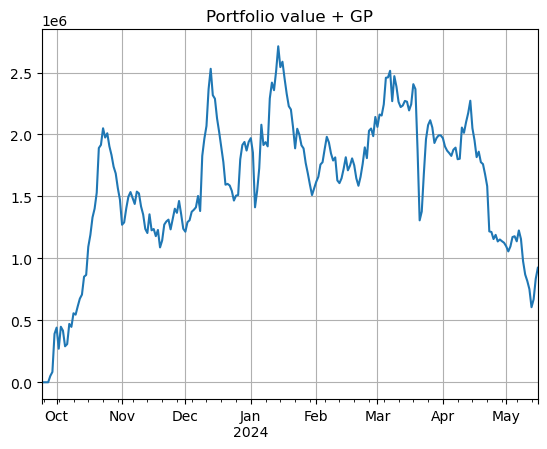

Total PnL: 924344.0
Final inventory: 2


(1, 0, 1)


,sell,hold,buy
sell,0,61,23
hold,2,35,19
buy,2,60,34


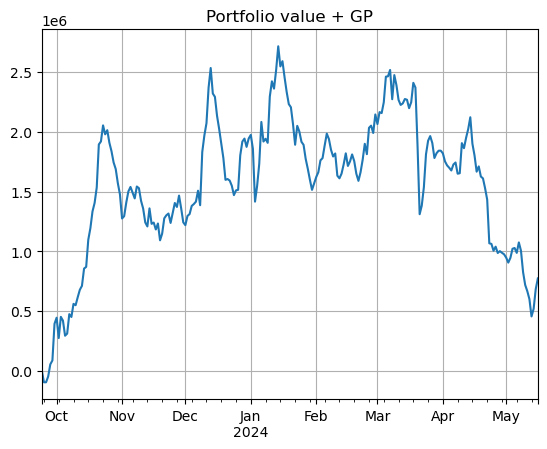

Total PnL: 773105.0
Final inventory: 2




In [82]:
# naive trading strategy of selling and buying when pred is outside of the 35th and 65th percentiles
# limit to one whip

from sklearn.metrics import confusion_matrix

q_s = .35
q_b = .65

Q_s, Q_b = (-.0075,.005)

inv_limit = 2
start_stack = 0

for order in orders:
    print(order)
    df_res = res[order]['ret_df']
    
    df_res['signal'] = 1*(df_res['Pred'] >= Q_b) - 1*(df_res['Pred'] <= Q_s)
    df_res['actual'] = 1*(df_res['Real'] >= Q_b) - 1*(df_res['Real'] <= Q_s)

    df_res = df_res.merge(df_tr, how='outer',left_index=True,right_index=True)
    df_res['VWAP_trade'] = df_res['VWAP'].shift(1)
    df_res = df_res.dropna()
    df_res = df_res.drop(['timestamp','highPriceVolume','lowPriceVolume'],axis=1)
    df_res.index = df_res.index.shift(-1,df_res.index.inferred_freq)

    display(pd.DataFrame(confusion_matrix(df_res['actual'],df_res['signal']),
                        index = ['sell','hold','buy'],columns=['sell','hold','buy']))
    
    pnl_result = osrs_GE.trading_strategy_pnler(df_res,inv_limit,start_stack = start_stack)

    print("Total PnL: {}".format((pnl_result.tail(1)['total_portfolio'].values[0] - start_stack).round()))
    print("Final inventory: {}".format(int(pnl_result.tail(1)['inventory'].values[0])))
    print('\n')

Order: ARIMA (1, 0, 0)


,sell,hold,buy
sell,0,17,5
hold,1,28,5
buy,1,40,14


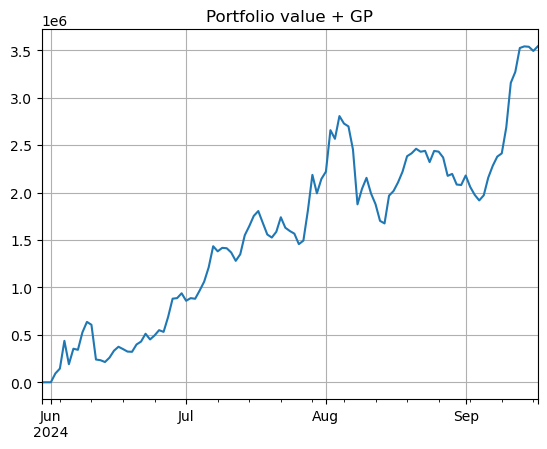

Total PnL: 3541974.0
Final inventory: 2


Order: ARIMA (1, 0, 1)


,sell,hold,buy
sell,0,17,5
hold,0,28,6
buy,1,40,14


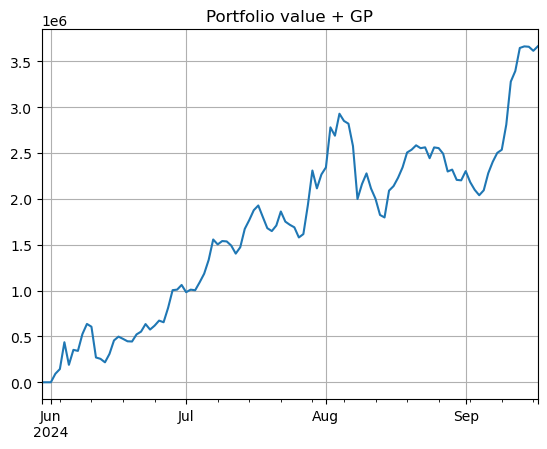

Total PnL: 3665594.0
Final inventory: 2




In [83]:
# testing on test set
start_stack = 0
inv_limit = 2

for order in orders:
    print("Order: ARIMA {}".format(order))
    res_dict = osrs_GE.ARIMA_CV_SCORE(df['simpRet'],
                                      order=order,
                                     start_point=train_idx,
                                     custom_scorer=osrs_GE.elliptic_paraboloid_loss)
    
    df_res = res_dict['ret_df']
    df_res['signal'] = 1*(df_res['Pred'] >= Q_b) - 1*(df_res['Pred'] <= Q_s)
    df_res['actual'] = 1*(df_res['Real'] >= Q_b) - 1*(df_res['Real'] <= Q_s)

    df_res = df_res.merge(df, how='outer',left_index=True,right_index=True)
    df_res['VWAP_trade'] = df_res['VWAP'].shift(1)
    df_res = df_res.dropna()
    df_res = df_res.drop(['timestamp','highPriceVolume','lowPriceVolume'],axis=1)
    df_res.index = df_res.index.shift(-1,df_res.index.inferred_freq)

    display(pd.DataFrame(confusion_matrix(df_res['actual'],df_res['signal']),
                        index = ['sell','hold','buy'],columns=['sell','hold','buy']))
    
    pnl_result = osrs_GE.trading_strategy_pnler(df_res,inv_limit,start_stack = start_stack)
    
    print("Total PnL: {}".format((pnl_result.tail(1)['total_portfolio'].values[0] - start_stack).round()))
    print("Final inventory: {}".format(int(pnl_result.tail(1)['inventory'].values[0])))
    print('\n')

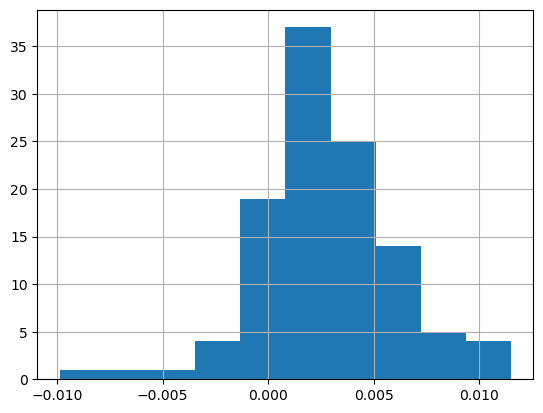

In [84]:
df_res['Pred'].hist()
plt.show()

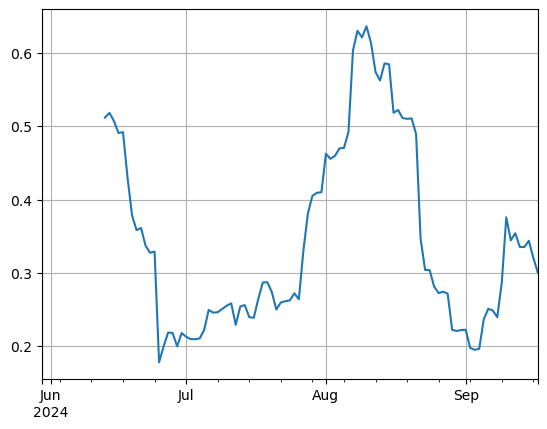

In [85]:
(df_res['Real'].rolling(window=15,min_periods=15).std()*np.sqrt(365)).plot()
plt.grid()
plt.axvline(pd.to_datetime(train_dt), linewidth=1, label='Train/Test Split', alpha=1.0)
plt.show()